# Modèle de la production éolienne Suisse

Ce modèle utilise :
- les installations éoliennes suisses (données SFOE/OFEN) avec leurs coordonnées géographiques
- les facteurs de production éolienne par région NUTS2 (données dérivées de ERA5, voir https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.4bd77450)

Il permet de calculer la production éolienne Suisse totale et par région NUTS2.

In [1]:
import pandas as pd

wind_plants = pd.read_csv('./data/CH_ElectricityProductionPlant_final.csv', parse_dates=True)
wind_plants = wind_plants[wind_plants['SubCategory'] == 'Wind_Onshore_CH']

In [2]:
wind_plants

,Unnamed: 0,xtf_id,Canton,BeginningOfOperation,InitialPower,TotalPower,SubCategory,PlantCategory,_x,_y,CumulativePower
1151,168931,8801,ZH,2000-11-02,7.0,7.0,Wind_Onshore_CH,NaN,2693622.0,1263996.0,7.0
1152,168930,9477,ZH,2000-11-02,7.0,7.0,Wind_Onshore_CH,NaN,2693622.0,1263996.0,14.0
1287,169088,8898,ZH,2002-04-01,6.4,6.4,Wind_Onshore_CH,NaN,2692041.0,1259079.0,20.4
1304,168929,8772,ZH,2002-06-21,7.0,7.0,Wind_Onshore_CH,NaN,2700021.0,1265400.0,27.4
1309,168610,8361,SO,2002-07-02,6.4,6.4,Wind_Onshore_CH,NaN,2607190.0,1232287.0,33.8
...,...,...,...,...,...,...,...,...,...,...,...
113640,47,13578,TI,2020-10-08,2550.0,2550.0,Wind_Onshore_CH,NaN,2685668.0,1157159.0,78168.8
114193,12,13179,TI,2020-10-19,2550.0,2550.0,Wind_Onshore_CH,NaN,2686253.0,1157143.0,80718.8
114922,45,13582,TI,2020-10-29,2550.0,2550.0,Wind_Onshore_CH,NaN,2685655.0,1157555.0,83268.8
116126,20,13171,TI,2020-11-16,2550.0,2550.0,Wind_Onshore_CH,NaN,2686251.0,1156372.0,85818.8


#### Mapping de leurs positions vers les régions NUTS niveau 2
Les coordonnées _x et _y sont au format MN95 (EPSG:2056) (système de coordonnées suisse) : on les convertit en degrés décimaux (EPSG:4326) (longitude/latitude GPS) pour pouvoir les classer dans les régions NUTS2.

In [26]:
from math import isnan
from shapely import Point
import geopandas as gpd
from pyproj import Transformer

# Définir la projection
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326")  # MN95 -> WGS84

# Charger la carte NUTS2 dans geopandas
nuts2 = gpd.read_file("./data/NUTS_RG_01M_2021_4326_LEVL_2.geojson")
ch_nuts = nuts2[nuts2['CNTR_CODE'] == 'CH']

# Créer une colonne vide pour stocker le nom de la région
wind_plants['region'] = 'glagla'  # Valeur par défaut pour les installations sans coordonnées

# Boucler sur chaque paire de coordonnées MN95
for i in wind_plants.index:
    if isnan(wind_plants.loc[i, '_x']) or isnan(wind_plants.loc[i, '_y']):
        continue
    # Convertir les coordonnées en degrés décimaux
    lat, lon = transformer.transform(wind_plants.loc[i, '_x'], wind_plants.loc[i, '_y'])
    point = Point(lon, lat)

    # Trouver la région correspondante dans la carte NUTS2
    for index, row in ch_nuts.iterrows():
        if row.geometry.contains(point):
            wind_plants.loc[i, 'region'] = row.NUTS_ID
            break

# Afficher la liste de coordonnées classées par région
print(wind_plants.groupby('region').size())

region
CH01     7
CH02    30
CH03     1
CH04     8
CH05     8
CH06     9
CH07     5
dtype: int64


In [27]:
installed_power = wind_plants['TotalPower'].sum()
print('Puissance des éoliennes installées au 30 Avril 2023 :', installed_power, 'kWc')

Puissance des éoliennes installées au 30 Avril 2023 : 88368.8 kWc


In [28]:
wind_plants_2021 = wind_plants[wind_plants['BeginningOfOperation'] < '2022-01-01']
installed_power_2021 = wind_plants_2021['TotalPower'].sum()
print('Puissance des éoliennes installées avant 2022 :', installed_power_2021, 'kWc')

Puissance des éoliennes installées avant 2022 : 88368.8 kWc


In [29]:
wind_plants_2022 = wind_plants[wind_plants['BeginningOfOperation'] < '2023-01-01']
installed_power_2022 = wind_plants_2022['TotalPower'].sum()
print('Puissance des éoliennes installées avant 2023 :', installed_power_2022, 'kWc')

Puissance des éoliennes installées avant 2023 : 88368.8 kWc


In [30]:
diff_21_22 = wind_plants[wind_plants['BeginningOfOperation'] < '2022-01-01']['TotalPower'].sum() - \
             wind_plants[wind_plants['BeginningOfOperation'] < '2021-01-01']['TotalPower'].sum()
print('Puissance installée entre 2021 et 2022 : ', diff_21_22)

Puissance installée entre 2021 et 2022 :  0.0


Valeur OFEN : 86.94 MWc

In [31]:
ofen_data = {
    '2009-01-01': 13.56,
    '2010-01-01': 17.56,
    '2011-01-01': 42.26,
    '2012-01-01': 45.51,
    '2013-01-01': 49.42,
    '2014-01-01': 60.29,
    '2015-01-01': 60.29,
    '2016-01-01': 60.29,
    '2017-01-01': 75.37,
    '2018-01-01': 75.37,
    '2019-01-01': 75.37,
    '2020-01-01': 75.37,
    '2021-01-01': 87.12,
    '2022-01-01': 86.94
}
ofen_data = pd.DataFrame.from_dict(ofen_data, orient='index', columns=['installed_ofen'])
ofen_data.index = pd.to_datetime(ofen_data.index)
ofen_data = ofen_data.resample('M').max().interpolate(method='linear', limit_direction='forward')

In [32]:
by_date = wind_plants.groupby('BeginningOfOperation')['CumulativePower'].max()
by_date.index = pd.to_datetime(by_date.index)
by_date_c = by_date['2009-01-01':] / 1000
data_monthly = by_date_c.resample('M').max().fillna(method='ffill')

#ofen_data['correction'] = 1
#for m in ofen_data.index:
#    ofen_data.loc[m, 'correction'] = data_monthly[m] / ofen_data.loc[m, 'installed_ofen']

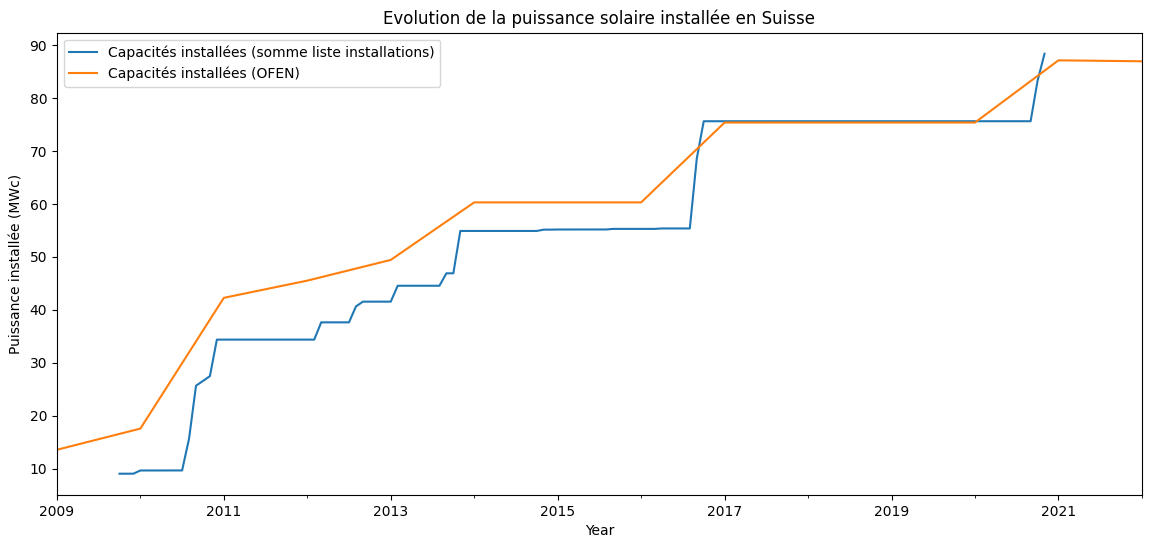

In [33]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))
data_monthly.plot(ax=ax, label='Capacités installées (somme liste installations)', legend=True)
ofen_data['installed_ofen'].plot(ax=ax, label='Capacités installées (OFEN)', legend=True)
ax.set_ylabel('Puissance installée (MWc)')
ax.set_xlabel('Year')
ax.set_title('Evolution de la puissance solaire installée en Suisse');

### 2. Facteur de charge des éoliennes par emplacement

**/!\ Les régions NUTS-2 ne sont pas pertinentes car tous les points de la région ont le même poids et on obtient des facteurs de charge sous-évalués**

Les facteurs de charge sont issus des données ERA5 (voir https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.4bd77450) pour chaque région NUTS2.
On lit simplement le fichier csv les contenant.

In [2]:
wind_factor = pd.read_csv(
    './data/H_ERA5_ECMW_T639_WON_0100m_Euro_NUT2_S197901010000_E202304302300_CFR_TIM_01h_NA-_noc_org_NA_NA---_NA---_PhM01.csv',
    skiprows=52,
    parse_dates=True,
    index_col='Date')

# le fichier contient tout l'Europe, on ne garde que la Suisse
wind_factor = wind_factor.drop(columns=[col for col in wind_factor.columns if not col.startswith('CH')])
wind_factor.fillna(0, inplace=True)

In [66]:
from os import listdir
import xarray as xr
import pandas as pd

files = listdir('./data/wind_2021')
dfs = []
for f in files:
    #f = 'H_ERA5_ECMW_T639_WON_0100m_Euro_025d_S202106010000_E202106302300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM01.nc'
    #f = 'H_ERA5_ECMW_T639_WON_0100m_Euro_025d_S202109010000_E202109302300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM01.nc'
    #f = 'H_ERA5_ECMW_T639_WON_0100m_Euro_025d_S202110010000_E202110312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM01.nc'
    print('Read:', f)
    ds2 = xr.open_dataset(f'./data/wind_2021/{f}')
    dfs.append(ds2.to_dataframe().dropna())
    del ds2
    break
wind_factor = pd.concat(dfs)

Read: H_ERA5_ECMW_T639_WON_0100m_Euro_025d_S202101010000_E202101312300_CFR_MAP_01h_NA-_noc_org_NA_NA---_NA---_PhM01.nc


In [67]:
wd40 = wind_factor.reset_index()

In [68]:
wd40[['longitude', 'latitude']].drop_duplicates()

,longitude,latitude
0,-22.0,71.25
744,-22.0,71.00
1488,-22.0,70.75
2232,-22.0,66.25
2976,-22.0,66.00
...,...,...
19341024,45.5,27.50
19341768,45.5,27.25
19342512,45.5,27.00
19343256,45.5,26.75


In [69]:
from math import isnan
import numpy as np
from pyproj import Transformer
from scipy.spatial.distance import cdist

transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326")  # MN95 -> WGS84

grid = wd40[['longitude', 'latitude']].drop_duplicates()#gpt nul wind_factor.index.get_level_values(['longitude', 'latitude']).unique()
del wd40

def trouver_position_proche(row):
    if isnan(row['_x']) or isnan(row['_y']):
        return 0, 0
    positions_grid = grid
    # Convertir les coordonnées en degrés décimaux
    lat, lon = transformer.transform(row['_x'], row['_y'])
    centrale_position = np.array([lon, lat])
    distances = cdist([centrale_position], positions_grid)
    index_plus_proche = np.argmin(distances)
    pos = positions_grid.iloc[index_plus_proche]
    return pos['longitude'], pos['latitude']

# Attribution des positions les plus proches aux centrales
psl = wind_plants.apply(trouver_position_proche, axis=1)
wind_plants['long'], wind_plants['lat'] = [p[0] for p in psl], [p[1] for p in psl]
wind_plants

,Unnamed: 0,xtf_id,Canton,BeginningOfOperation,InitialPower,TotalPower,SubCategory,PlantCategory,_x,_y,CumulativePower,long,lat
1151,168931,8801,ZH,2000-11-02,7.0,7.0,Wind_Onshore_CH,NaN,2693622.0,1263996.0,7.0,8.75,47.50
1152,168930,9477,ZH,2000-11-02,7.0,7.0,Wind_Onshore_CH,NaN,2693622.0,1263996.0,14.0,8.75,47.50
1287,169088,8898,ZH,2002-04-01,6.4,6.4,Wind_Onshore_CH,NaN,2692041.0,1259079.0,20.4,8.75,47.50
1304,168929,8772,ZH,2002-06-21,7.0,7.0,Wind_Onshore_CH,NaN,2700021.0,1265400.0,27.4,8.75,47.50
1309,168610,8361,SO,2002-07-02,6.4,6.4,Wind_Onshore_CH,NaN,2607190.0,1232287.0,33.8,7.50,47.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113640,47,13578,TI,2020-10-08,2550.0,2550.0,Wind_Onshore_CH,NaN,2685668.0,1157159.0,78168.8,8.50,46.50
114193,12,13179,TI,2020-10-19,2550.0,2550.0,Wind_Onshore_CH,NaN,2686253.0,1157143.0,80718.8,8.50,46.50
114922,45,13582,TI,2020-10-29,2550.0,2550.0,Wind_Onshore_CH,NaN,2685655.0,1157555.0,83268.8,8.50,46.50
116126,20,13171,TI,2020-11-16,2550.0,2550.0,Wind_Onshore_CH,NaN,2686251.0,1156372.0,85818.8,8.50,46.50


In [70]:
unique_pos = [(x, y) for x, y in zip(wind_plants['long'], wind_plants['lat'])]
print(len(unique_pos), 'vs', len(wind_plants))
unique_pos = list(set(unique_pos))
print('create frame')
wind_factor_reduced = pd.DataFrame(index=wind_factor.index.levels[2])
print('reducing...')
for pos in unique_pos:
    #print(pos, 'is', wind_factor.loc[pos[0], pos[1]], '//', wind_factor_reduced[pos])
    wind_factor_reduced[str(pos)] = wind_factor.loc[pos[0], pos[1]]
#wind_factor_reduced

68 vs 68
create frame
reducing...


C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_2252\470641119.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  wind_factor_reduced[str(pos)] = wind_factor.loc[pos[0], pos[1]]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_2252\470641119.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  wind_factor_reduced[str(pos)] = wind_factor.loc[pos[0], pos[1]]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_2252\470641119.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  wind_factor_reduced[str(pos)] = wind_factor.loc[pos[0], pos[1]]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_2252\470641119.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  wind_factor_reduced[str(pos)] = wind_factor.loc[pos[0], pos[1]]
C:\Users\aymeric.bourdy\AppData\Local\Temp\ipykernel_2252\470641119.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  wind

In [71]:
start = '2021-01-01'
end = '2021-01-31'
freq = 'D'
print('step 1')

# Générer un DataFrame avec l'index des dates
dates = pd.date_range(start=start, end=end, freq=freq)
by_date = pd.DataFrame(index=dates)
print('step 2')

# Calculer la puissance cumulée pour chaque région
regions = unique_pos
szh = len(regions)
i = 0
for region in regions:
    # Filtrer les installations pour la région donnée
    #print('Region is ', region, ' ', i,'/',szh)
    df_region = wind_plants[(wind_plants['long'] == region[0]) & (wind_plants['lat'] == region[1])]
    if len(df_region) == 0:
        continue
    #print('ERROR df reg is ', df_region, ' for ', region)

    # Regrouper par date de début d'opération et calculer la somme de la puissance
    df_grouped = df_region.groupby('BeginningOfOperation')['TotalPower'].sum()
    df_grouped.index = pd.to_datetime(df_grouped.index)

    # Puissance installée au début de l'année
    base_value = df_grouped.loc[:start].sum()
    # Réindexer pour inclure toutes les dates entre d1 et d2
    df_grouped = df_grouped.reindex(dates, fill_value=0)
    df_grouped.loc[start] = base_value
    #print('Power in ', region,' is ', df_grouped.cumsum())

    # Ajouter la colonne de puissance cumulée de la région au DataFrame de sortie
    by_date[str(region)] = df_grouped.cumsum()
    i = i + 1
by_date = by_date / 1000  # Convertir en MWc

step 1
step 2


In [72]:
by_date.iloc[-1].sum()

88.3688

In [50]:
wind_factor_reduced

,"(7.75, 47.0)","(7.75, 47.25)","(7.0, 47.25)","(7.0, 47.0)","(8.25, 46.5)","(9.0, 47.25)","(8.5, 47.75)","(7.25, 47.25)","(7.75, 46.75)","(7.0, 46.25)",...,"(8.75, 47.75)","(8.0, 47.25)","(8.0, 47.0)","(8.5, 46.75)","(8.5, 46.5)","(7.25, 46.25)","(7.5, 47.25)","(9.5, 47.0)","(9.5, 47.5)","(8.25, 47.25)"
time,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:00:00,0.125993,0.292122,0.385607,0.351302,0.000000,0.006664,0.242614,0.291876,0.002355,0.000000,...,0.225592,0.241336,0.067290,0.000000,0.000700,0.000000,0.275738,0.000000,0.002991,0.107618
2021-09-01 01:00:00,0.072731,0.247982,0.314993,0.245490,0.000000,0.005261,0.294087,0.231345,0.000359,0.000000,...,0.269229,0.199965,0.022814,0.000000,0.000000,0.000000,0.226680,0.000000,0.012015,0.086170
2021-09-01 02:00:00,0.068925,0.252334,0.274603,0.185407,0.000010,0.005069,0.281767,0.216377,0.000000,0.000000,...,0.236066,0.213214,0.025814,0.000000,0.000000,0.000000,0.224012,0.000000,0.004913,0.088444
2021-09-01 03:00:00,0.059723,0.204047,0.252966,0.202922,0.000000,0.006845,0.223282,0.188085,0.000000,0.000000,...,0.184609,0.146838,0.011320,0.000000,0.000047,0.000000,0.192334,0.000000,0.000250,0.041873
2021-09-01 04:00:00,0.055281,0.188521,0.238831,0.188401,0.000001,0.018160,0.216337,0.173820,0.000000,0.000000,...,0.170289,0.127735,0.008250,0.000000,0.000000,0.000000,0.181425,0.000118,0.000000,0.029351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30 19:00:00,0.000615,0.004671,0.019195,0.002993,0.000000,0.000000,0.000000,0.016865,0.000005,0.000000,...,0.000000,0.000504,0.000000,0.000000,0.000000,0.000010,0.012370,0.000000,0.000009,0.000000
2021-09-30 20:00:00,0.000000,0.000000,0.004115,0.000110,0.000000,0.000000,0.000001,0.001264,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000468,0.000000,0.000005,0.000179,0.000000,0.000010,0.000010
2021-09-30 21:00:00,0.000004,0.000000,0.002341,0.000000,0.000000,0.000008,0.000004,0.000000,0.000120,0.000000,...,0.000000,0.000001,0.000009,0.002404,0.000348,0.000000,0.000000,0.000000,0.000000,0.000010


In [51]:
# Day by day
solar_factor_resampled = wind_factor_reduced.resample(freq).mean().loc[start:end]
n_hours_freq = 24 if freq == 'D' else 1
produced_year = solar_factor_resampled.multiply(by_date).sum(axis=1) * n_hours_freq
produced_year = produced_year / 1000  # Convertir en GWh

In [73]:
#hour by hour
by_date_rs = by_date.resample('H').first().loc[start:end]
by_date_rs = by_date_rs.interpolate(method='pad', limit_direction='forward')
rd = wind_factor_reduced.loc[start:end]
produced_year = rd.multiply(by_date_rs).sum(axis=1)
produced_year = produced_year / 1000  # Convertir en GWh

# Janvier

In [74]:
produced_year.sum()

10.194308785475481

# Juin

In [41]:
produced_year.sum()

1.2631451358042447

# Septembre

In [54]:
produced_year.sum()

1.6957400323341778

# Octobre

In [65]:
produced_year.sum()

4.940536067843557

In [ ]:
from math import isnan
from shapely import Point
import geopandas as gpd
from pyproj import Transformer

# Définir la projection
transformer = Transformer.from_crs("EPSG:2056", "EPSG:4326")  # MN95 -> WGS84

# Créer une colonne vide pour stocker la case la plus proche
wind_plants['longitude'] = 0  # Valeur par défaut pour les installations sans coordonnées
wind_plants['latitude'] = 0  # Valeur par défaut pour les installations sans coordonnées

# Boucler sur chaque paire de coordonnées MN95
for i in wind_plants.index:
    if isnan(wind_plants.loc[i, '_x']) or isnan(wind_plants.loc[i, '_y']):
        continue
    # Convertir les coordonnées en degrés décimaux
    lat, lon = transformer.transform(wind_plants.loc[i, '_x'], wind_plants.loc[i, '_y'])


# Afficher la liste de coordonnées classées par région
print(wind_plants.groupby('region').size())

### 3. Calcul de la production éolienne suisse

#### 2021

In [81]:
start = '2021-01-01'
end = '2021-12-31'
freq = 'D'

In [82]:
# Générer un DataFrame avec l'index des dates
dates = pd.date_range(start=start, end=end, freq=freq)
by_date = pd.DataFrame(index=dates)

# Calculer la puissance cumulée pour chaque région
regions = wind_plants['region'].unique()
for region in regions:
    # Filtrer les installations pour la région donnée
    df_region = wind_plants[wind_plants['region'] == region]

    # Regrouper par date de début d'opération et calculer la somme de la puissance
    df_grouped = df_region.groupby('BeginningOfOperation')['TotalPower'].sum()
    df_grouped.index = pd.to_datetime(df_grouped.index)

    # Puissance installée au début de l'année
    base_value = df_grouped.loc[:start].sum()
    # Réindexer pour inclure toutes les dates entre d1 et d2
    df_grouped = df_grouped.reindex(dates, fill_value=0)
    df_grouped.loc[start] = base_value
    print('Power in ', region,' is ', df_grouped.cumsum())

    # Ajouter la colonne de puissance cumulée de la région au DataFrame de sortie
    by_date[region] = df_grouped.cumsum()
by_date = by_date / 1000  # Convertir en MWc
solar_factor_resampled = wind_factor.resample(freq).mean().loc[start:end]
n_hours_freq = 24 if freq == 'D' else 1
produced_year = solar_factor_resampled.multiply(by_date).sum(axis=1) * n_hours_freq
produced_year = produced_year / 1000  # Convertir en GWh

Power in  CH04  is  2021-01-01    60.7
2021-01-02    60.7
2021-01-03    60.7
2021-01-04    60.7
2021-01-05    60.7
              ... 
2021-12-27    60.7
2021-12-28    60.7
2021-12-29    60.7
2021-12-30    60.7
2021-12-31    60.7
Freq: D, Name: TotalPower, Length: 365, dtype: float64
Power in  CH02  is  2021-01-01    48179.7
2021-01-02    48179.7
2021-01-03    48179.7
2021-01-04    48179.7
2021-01-05    48179.7
               ...   
2021-12-27    48179.7
2021-12-28    48179.7
2021-12-29    48179.7
2021-12-30    48179.7
2021-12-31    48179.7
Freq: D, Name: TotalPower, Length: 365, dtype: float64
Power in  CH05  is  2021-01-01    3476.4
2021-01-02    3476.4
2021-01-03    3476.4
2021-01-04    3476.4
2021-01-05    3476.4
               ...  
2021-12-27    3476.4
2021-12-28    3476.4
2021-12-29    3476.4
2021-12-30    3476.4
2021-12-31    3476.4
Freq: D, Name: TotalPower, Length: 365, dtype: float64
Power in  CH06  is  2021-01-01    7542.0
2021-01-02    7542.0
2021-01-03    7542.0
2021-01-04

In [83]:
produced_year.resample('M').sum()

Date
2021-01-31    4.887264
2021-02-28    2.789748
2021-03-31    3.592883
2021-04-30    2.840298
2021-05-31    4.182061
2021-06-30    0.736214
2021-07-31    1.742637
2021-08-31    1.370302
2021-09-30    0.689666
2021-10-31    2.540191
2021-11-30    2.164911
2021-12-31    4.492138
Freq: M, dtype: float64

In [56]:
produced_year.sum()

30.63396419888679

Valeur IEA et OFEN : 145.6 GWh

--- AVG yield ---

In [91]:
solar_factor_resampled.mean().mean()

0.04458562853561637

In [95]:
# OFEN
145.6 / 8760 / 86.94 * 1000

0.19117787630791405

In [103]:
30.63396419888679 * 0.19117787630791405 / 0.04458562853561637

131.3547977406546

In [58]:
iea_data = {
    '2021-01-31': 16.2,
    '2021-02-28': 16.2,
    '2021-03-31': 12.1,
    '2021-04-30': 11.1,
    '2021-05-31': 16.2,
    '2021-06-30': 7.1,
    '2021-07-31': 9.1,
    '2021-08-31': 9.1,
    '2021-09-30': 7.1,
    '2021-10-31': 14.2,
    '2021-11-30': 9.1,
    '2021-12-31': 18.2
}
iea_data = pd.DataFrame.from_dict(iea_data, orient='index', columns=['prod_iea'])

In [61]:
#######
# Data Pronovo.ch (https://www.energy-charts.info/)
#######
import pandas as pd
data = pd.read_csv("./data/energy-charts_Production_d'électricité_journalière__en_Suisse2021.csv", index_col='Jour')
data.index = pd.to_datetime(data.index, format='%d.%m.%Y')
data.drop(labels=['NaT'], inplace=True)
data = data.applymap(lambda x: float(x.replace(',', '.')))
pv = data['Éolienne'].resample('M').sum()

iea_data.index = pv.index

In [70]:
own_monthly = produced_year.resample('M').sum()
own_monthly.index = pv.index

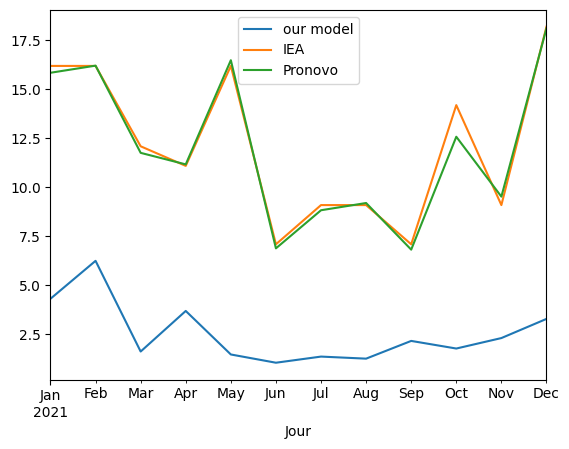

In [72]:
ax = plt.gca()
own_monthly.plot(ax=ax)
iea_data.plot(ax=ax)
pv.plot(ax=ax)
plt.legend(['our model', 'IEA', 'Pronovo']);

4. Data Quality
The Wind Power CFR data reconstruction quality has been assessed for each individual country over the historical period, using ENTSO-E and some other Transmission System Operators data. Due to the assumptions made, it is not expected that the Wind Power CFR closely resembles the observed one, but its temporal evolution is realistic.